In [55]:
import sklearn
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
from sklearn import cross_validation, ensemble, metrics
% matplotlib inline

In [ ]:
dbcreds = {}
with open('dbconfig.profile') as f:
    for line in f.readlines():
        row = line.split(" ")[1].split("=")
        dbcreds[row[0]] = row[1].strip()

engine = create_engine('postgresql://{}:{}@{}/{}'.format(
              dbcreds['PGUSER'], dbcreds['PGPASSWORD'],
              dbcreds['PGHOST'], dbcreds['PGDATABASE']))

Note this is for demonstration of a machine learning workflow where the features are grabbed directly from the database and then machine learning and evaluation is performed using `scikit-learn`. Results look suspiciously good (for a three feature model with no model selection or hyperparameter optimization) because the base rate in the testing set is artificially high. We oversample the SD class for training and I have not rebalanced the testing set to reflect reality (we also don't know the base rate in reality but that's a story for another day). 

# Feature Extraction

Grab features and the label from database:

In [26]:
labelled_query = ('select t1.*, t3.is_sd from features.frontpage_features t1 '
                   'inner join raw.frontpage_examples t2 '
                   'on t1.exampleid = t2.exampleid '
                   'inner join raw.hs_history t3 '
                   'on t3.hsid = t2.hsid')

df = pd.read_sql(labelled_query, engine)

In [28]:
df.columns

Index(['exampleid', 'total_number_of_cells', 'total_number_of_incoming_cells',
       'total_number_of_outgoing_cells', 'is_sd'],
      dtype='object')

x will be our feature set:

In [29]:
x = df[['total_number_of_cells', 'total_number_of_incoming_cells', 'total_number_of_outgoing_cells']]

y will be our label:

In [32]:
y = df['is_sd'].astype(int)

Let's split our data into train and test sets using http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html:

In [38]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.33)

# Training

Use our training set to train a Random Forest model from http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html:

In [43]:
model = ensemble.RandomForestClassifier(n_estimators=10)
model.fit(x_train, y_train)

# Prediction

Using the trained model, predict for the test set: 

In [44]:
y_predicted = model.predict_proba(x_test)

# Evaluation

See how well we performed:

In [47]:
prob_sd = y_predicted[:, 1]

This array `prob_sd` contains the probability that the given trace is that of a user connecting to a SecureDrop instance:

In [61]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_sd, pos_label=1)
metrics.auc(fpr, tpr)

0.93825634352635001

In [71]:
fpr, tpr

(array([ 0.        ,  0.00689655,  0.02068966,  0.02758621,  0.03448276,
         0.04827586,  0.05517241,  0.09655172,  0.11034483,  0.14482759,
         0.17931034,  0.22758621,  1.        ]),
 array([ 0.        ,  0.24528302,  0.39622642,  0.47169811,  0.47169811,
         0.54716981,  0.64150943,  0.77358491,  0.8490566 ,  0.9245283 ,
         0.96226415,  0.98113208,  1.        ]))

## Confusion Matrix

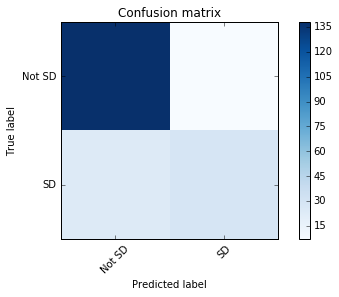

In [94]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    class_names = ['Not SD', 'SD']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def set_threshold(predictions, x_proportion):
    cutoff_index = int(len(predictions) * x_proportion)
    cutoff_index = min(cutoff_index, len(predictions) - 1)
    sorted_by_probability = np.sort(predictions)[::-1]
    cutoff_probability = sorted_by_probability[cutoff_index]
    predictions_binary = [ 1 if x > cutoff_probability else 0 for x in predictions ]
    return predictions_binary

# Compute confusion matrix
cm = metrics.confusion_matrix(y_test, set_threshold(prob_sd, 0.2))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)

## ROC (True positive rate v False positive rate)

In [66]:
def plot_ROC(test_labels, test_predictions):
    fpr, tpr, thresholds = metrics.roc_curve(
        test_labels, test_predictions, pos_label=1)
    auc = "%.2f" % metrics.auc(fpr, tpr)
    title = 'ROC Curve, AUC = '+str(auc)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "#000099", label='ROC curve')
        ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.title(title)
    return fig

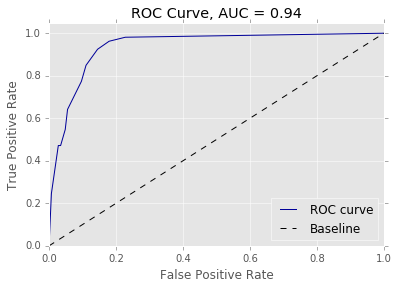

In [70]:
fig2 = plot_ROC(y_test, prob_sd)

And one can read off this last plot to compare with TPR and FPR reported in literature. 